# Training an Autoencoder with ResNet to do image similarity search

Data downloaded from [artificio](https://github.com/ankonzoid/artificio) and decoder was based on code from [ResNet-decoder](https://github.com/JiahongChen/ResNet-decoder)

In [18]:
import os
from os import path

import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset
from torchvision import io


class AutoEncoderDataset(Dataset):
    def __init__(self, images_dir: str):
        self.__image_paths: list[str] = self.__get_image_paths(images_dir)

    def __len__(self) -> int:
        return len(self.__image_paths)

    def __getitem__(self, index):
        img_path = self.__image_paths[index]
        image = io.read_image(img_path)
        image = image.float()
        image = image / 255
        label = image.clone()
        return image, label

    def __get_image_paths(self, images_dir: str) -> list[str]:
        """Returns a list containing the absolute path to each file inside the directory
        """
        file_paths = []
        dir_abs_route = path.abspath(images_dir)
        files = os.listdir(dir_abs_route)
        for file in files:
            abs_filename = path.join(dir_abs_route, file)
            file_paths.append(abs_filename)
        return sorted(file_paths)


def imshow(img):
    npimg = np.array(img)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def print_loss_history(epoch_losses: list[float]):
    epochs = range(1, len(epoch_losses) + 1)
    plt.plot(epochs, epoch_losses, "bo", label="Training loss")
    plt.title("Training loss")
    plt.legend()
    plt.figure()
    plt.show()

In [19]:
from typing import Callable

import torch
from torch import Tensor
from torch.nn import BatchNorm2d, Conv2d, ConvTranspose2d, Identity, Module, ReLU, Sequential, Sigmoid, Upsample
from torchvision import models
from torchvision.models.resnet import ResNet


class DecoderBottleneck(Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition"https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion: int = 4

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        output_padding: int = 0,
        upsample: Module | None = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Callable[..., Module] | None = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = BatchNorm2d
        width = int(planes * (base_width / 64.0)) * groups
        # Both self.conv2 and self.upsample layers upsample the input when stride != 1
        self.conv3 = conv1x1(planes * self.expansion, width)
        self.bn3 = norm_layer(planes)
        self.conv2 = conv3x3(width, width, stride, groups, dilation, output_padding)
        self.bn2 = norm_layer(width)
        self.conv1 = conv1x1(width, inplanes)
        self.bn1 = norm_layer(inplanes)
        self.relu = ReLU(inplace=True)
        self.upsample = upsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x
        out = self.conv3(x)
        out = self.bn3(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv1(out)
        out = self.bn1(out)
        if self.upsample is not None:
            identity = self.upsample(x)
        out += identity
        out = self.relu(out)

        return out


class ResNetDecoder(Module):
    def __init__(self, block, layers: list[int]):
        super().__init__()
        self._norm_layer = BatchNorm2d
        self.inplanes = 2048
        self.dilation = 1

        self.unsample = Upsample(size=7, mode="nearest")
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer1 = self._make_layer(block, 64, layers[0], output_padding = 0, last_block_dim=64)
        self.image_output = Sequential(
            ConvTranspose2d(64, 3, kernel_size=2, stride=2, padding=6, dilation=1),
            Sigmoid()
        )

    def forward(self, x):
        x = torch.unflatten(x, 1, (2048, 1, 1))
        x = self.unsample(x)
        x = self.layer4(x)
        x = self.layer3(x)
        x = self.layer2(x)
        x = self.layer1(x)
        x = self.image_output(x)
        return x

    def _make_layer(
        self,
        block,
        planes: int,
        blocks: int,
        stride: int = 1,
        output_padding: int = 1,
        last_block_dim: int = 0,
    ) -> Sequential:
        norm_layer = self._norm_layer
        upsample = None
        previous_dilation = self.dilation
        self.groups = 1
        self.base_width = 64
        layers = []
        self.inplanes = planes * block.expansion
        if last_block_dim == 0:
            last_block_dim = self.inplanes // 2
        if stride != 1 or self.inplanes != planes * block.expansion or output_padding == 0:
            upsample = Sequential(
                conv1x1(planes * block.expansion, last_block_dim, stride, output_padding),
                # norm_layer(planes * block.expansion),
                norm_layer(last_block_dim),)
        last_block = block(
                last_block_dim, planes, stride, output_padding, upsample, self.groups,
                self.base_width, previous_dilation, norm_layer)
        for _ in range(1, blocks):
            layers.append(
                block(
                    self.inplanes,
                    planes,
                    groups=self.groups,
                    base_width=self.base_width,
                    dilation=self.dilation,
                    norm_layer=norm_layer))
        layers.append(last_block)
        return Sequential(*layers)


class ResNetAutoEncoder(Module):
    def __init__(self):
        super().__init__()
        encoder = models.resnet50()
        encoder = self.__modify_classification_head_for_embeddings(encoder)
        self.encoder = encoder
        self.decoder = ResNetDecoder(DecoderBottleneck, [3, 6, 4, 3])

    def forward(self, x: Tensor, embedding_only: bool = True):
        x = self.encoder(x)
        if not embedding_only:
            x = self.decoder(x)
        return x

    def __modify_classification_head_for_embeddings(self, encoder: ResNet) -> ResNet:
        encoder.fc = Identity()
        return encoder


def conv1x1(in_planes: int, out_planes: int, stride: int = 1, output_padding: int = 0) -> Conv2d:
    """1x1 convolution"""
    return ConvTranspose2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False,
                           output_padding=output_padding)


def conv3x3(
        in_planes: int,
        out_planes: int,
        stride: int = 1,
        groups: int = 1,
        dilation: int = 1,
        output_padding: int = 0
        ) -> Conv2d:
    """3x3 convolution with padding"""
    return ConvTranspose2d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=dilation,
        output_padding = output_padding,
        groups=groups,
        bias=False,
        dilation=dilation)

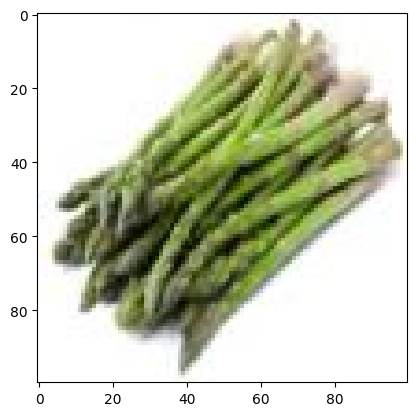

In [20]:
import random

from torch.utils.data import DataLoader

BATCH_SIZE = 4
trainset = AutoEncoderDataset("data/burguers_menu/train")
testset = AutoEncoderDataset("data/burguers_menu/test")
train_loader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader = DataLoader(testset, batch_size=1, shuffle=False, num_workers=2)
imshow(random.choice(trainset)[0])

In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [22]:
autoencoder = ResNetAutoEncoder()
autoencoder = autoencoder.to(device)
print(autoencoder)

ResNetAutoEncoder(
  (encoder): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(


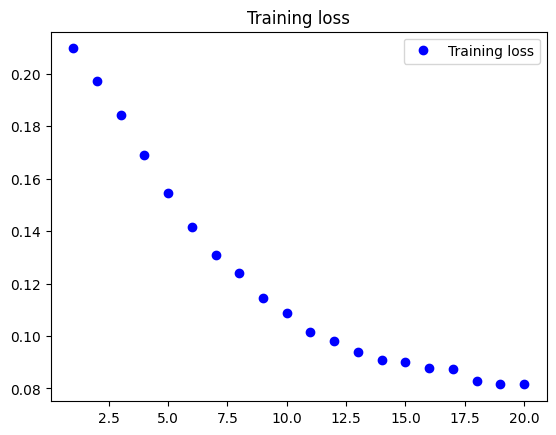

<Figure size 640x480 with 0 Axes>

In [23]:
from torch.nn import MSELoss
from torch.optim import SGD


EPOCHS = 20

criterion = MSELoss()
optimizer = SGD(autoencoder.parameters(), lr=0.005, momentum=0.9)
loss_history = []
for epoch in range(1, EPOCHS + 1):
    running_loss = 0
    for i, data in enumerate(train_loader):
        images, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = autoencoder(images, False)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_loss = running_loss/len(train_loader)
    loss_history.append(epoch_loss)
print_loss_history(loss_history)

In [24]:
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = autoencoder(images)
print(outputs[0].shape)
print(outputs[0])

torch.Size([2048])
tensor([0.9547, 0.9193, 0.8399,  ..., 0.9151, 0.7769, 0.8731], device='cuda:0')
